# Importing packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import tensorflow as tf

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler

In [2]:
from utils.preprocessing import *
from utils.fourier import *
from utils.plotting import *
from utils.model_performance import *
from utils.optuna_deep_learning import *

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
import warnings # Ignore alert messages
warnings.filterwarnings('ignore')

In [5]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})


In [6]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.integration import KerasPruningCallback

# Importing reduced dataset with engineered features

In [7]:
path = './datasets/railway_geometry_data'
file_names = get_file_names(folder_path=path, returns=False)
df = import_datasets([file_names[0]], import_file_name=False)

File names:  ['FRA4_vertical_track_irregularities.zip']
Number of files:  1


In [8]:
y = df['Vert_irreg_right_rail']
X = df.drop(['Vert_irreg_right_rail'],axis=1)

X_train1, X_test1, y_train1, y_test1 = create_scaled_dataset(X, y, test_size=0.2,shuffle=True)
X_train1

,Trail_right_z_sec_susp,Lead_left_z_sec_susp,Trail_left_z_sec_susp,Lead_right_z_sec_susp,Triaxial_x,Triaxial_z,Lead_z_accel_right_side,Susp_travel_left,Susp_travel_right,Pitch_accel,...,Triaxial_x_mean_55 samples,Triaxial_x_RMA_55 samples,Triaxial_x_MA_55 samples,Triaxial_x_RMS_55 samples,Triaxial_z_mean_55 samples,Susp_travel_mean_55 samples,Susp_travel_skew_55 samples,Pitch_left_susp_mean_55 samples,Bounce_susp_mean_55 samples,Front_Roll_susp_skew_55 samples
58674,-2.139678,2.187825,0.325739,-0.943770,-0.501985,-0.578528,0.057488,1.812885,-1.651042,-0.221914,...,0.231406,-0.044725,-0.146214,-0.197078,-0.575030,-0.118768,-0.015779,2.912296,-1.241740,1.130572
31896,-0.441991,0.401447,-0.300001,0.738838,-1.506027,0.334941,-0.133777,-0.279276,0.569557,-0.266280,...,0.895804,2.297036,2.684937,3.160013,-0.575292,0.866349,-0.995390,1.156211,1.394396,2.462448
47409,-0.287049,0.297097,-0.238668,0.359652,0.309656,0.258529,0.246516,-0.230686,-0.175673,0.244538,...,-0.970426,-0.427071,-0.501504,-0.146619,-1.582968,0.289756,0.191055,0.774944,0.803758,-1.767649
67333,-0.388562,0.219648,0.765644,-0.512853,0.502474,-0.345309,-0.195897,0.564978,-0.425044,0.297143,...,-1.023603,0.003175,-0.099587,-0.414502,-0.173822,0.934123,-0.456258,-0.378623,0.099269,0.331286
20576,0.259181,-0.245443,-0.113909,0.280493,0.373664,0.862172,0.344044,-0.131846,0.259326,0.418401,...,2.053168,1.102275,1.099761,1.345549,0.454551,0.113023,-0.411676,-0.087321,0.461619,0.857337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41993,1.589630,-1.238523,0.923601,-0.755717,1.036847,-0.154989,-0.250270,-0.918086,1.318849,0.095017,...,-0.551475,-0.021745,-0.123903,-0.124700,0.441582,0.432641,-0.538243,-2.421346,0.336160,-0.778910
21243,-0.203617,0.343219,-1.006723,1.208192,0.747186,0.920590,0.065630,-0.839175,0.942509,0.233406,...,0.999349,0.538260,0.453311,0.131849,0.131639,1.511391,-2.874798,0.096740,1.041459,0.647121
45891,0.393131,-0.363791,-0.158844,0.123813,1.207711,0.586685,-0.169681,-0.220881,0.365999,0.420904,...,0.380407,0.646426,0.572222,0.523591,-0.361221,-0.193719,-0.112012,-0.519650,-0.202116,0.229850
42613,0.370446,0.107775,1.206862,-1.310470,0.394024,0.670957,0.316728,0.914532,-1.058835,-0.367192,...,1.142881,-0.447987,-0.520074,-0.283958,0.104331,-0.827570,-0.805851,-1.368928,-0.551363,1.716408


# Vanilla neural network

In [10]:
vanilla_NN = optuna_vanilla_NN(X_train1, y_train1, X_test1, y_test1)

In [11]:
study = optuna.create_study(direction='minimize',
                             sampler=optuna.samplers.TPESampler(seed=10), # Fix a seed to have reproducible results
                             pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                             study_name='Vanilla_NN')

[I 2021-10-20 12:53:13,890] A new study created in memory with name: Vanilla_NN


In [13]:
study.optimize(vanilla_NN.objective, 
               n_trials=3,
               callbacks=[vanilla_NN.callback],
               show_progress_bar=True)

100%|██████████| 1/1 [46:51<00:00, 2812.00s/it]

[I 2021-10-20 14:22:47,959] Trial 3 finished with value: 2.466522216796875 and parameters: {'n_units_l0': 500, 'activ_fun_l0': 'tanh', 'n_units_l1': 1325, 'activ_fun_l1': 'linear', 'n_units_l2': 1475, 'activ_fun_l2': 'linear'}. Best is trial 1 with value: 0.7028340697288513.


In [14]:
best_model = vanilla_NN.best_model
best_model_history = vanilla_NN.history

In [15]:
best_model.save('models/NN/Vanilla_NN')

INFO:tensorflow:Assets written to: models/NN/Vanilla_NN\assets


In [18]:
vanilla_reconstructed_model = tf.keras.models.load_model("models/NN/Vanilla_NN")

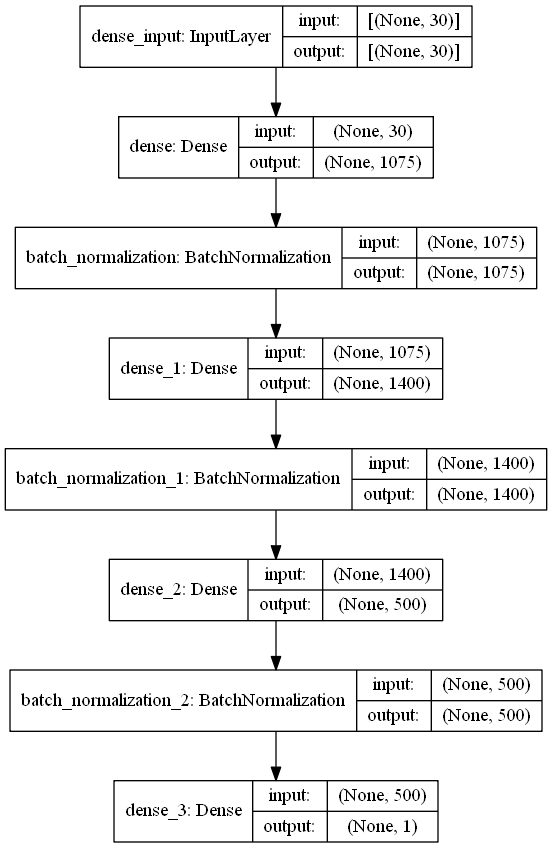

In [23]:
from keras.utils.vis_utils import plot_model
plot_model(vanilla_reconstructed_model,show_shapes=True, show_layer_names=True)

In [24]:
vanilla_reconstructed_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1075)              33325     
_________________________________________________________________
batch_normalization (BatchNo (None, 1075)              4300      
_________________________________________________________________
dense_1 (Dense)              (None, 1400)              1506400   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1400)              5600      
_________________________________________________________________
dense_2 (Dense)              (None, 500)               700500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

## Visualize statistics

In [25]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print('')
print('Best value')
print(study.best_value)
print('Best parameters')
print(study.best_params)

Study statistics: 
  Number of finished trials:  4
  Number of pruned trials:  0
  Number of complete trials:  3

Best value
0.7028340697288513
Best parameters
{'n_units_l0': 1075, 'activ_fun_l0': 'tanh', 'n_units_l1': 1400, 'activ_fun_l1': 'tanh', 'n_units_l2': 500, 'activ_fun_l2': 'relu'}


In [26]:
optuna.visualization.plot_optimization_history(study)

In [27]:
optuna.visualization.plot_slice(study) # best plot

## Model performance

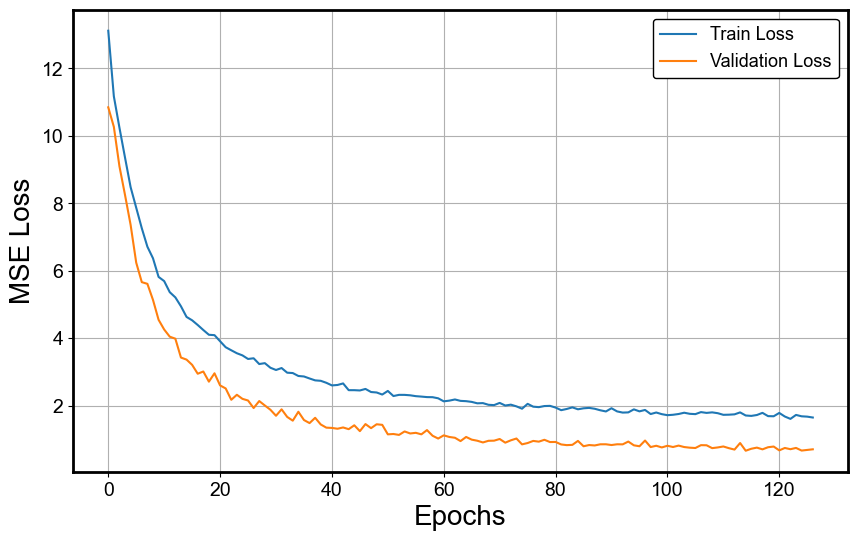

In [28]:
plot_learning_curve(best_model_history)

In [29]:
vanilla_reconstructed_model.evaluate(X_test1,y_test1)

426/426 [==============================] - 2s 3ms/step - loss: 0.7028


0.7028340697288513

In [30]:
yhat2 = vanilla_reconstructed_model.predict(X_test1)
metrics(yhat2,y_test1)

MSE:0.7028340858662163 
MAE:0.621822459891021 
R2:0.978937271830824


In [31]:
y_test_ordered = pd.DataFrame(y_test1.sort_index(ascending=True))
y_test_ordered=y_test_ordered.to_numpy()
y_test_ordered

array([[-0.0827],
       [-0.0928],
       [-0.0903],
       ...,
       [ 0.0535],
       [ 0.0558],
       [ 0.0578]])

In [32]:
X_test_ordered = X_test1.sort_index(ascending=True)
yhat = vanilla_reconstructed_model.predict(X_test_ordered)
yhat

array([[-0.09468853],
       [-0.2293933 ],
       [-0.37897494],
       ...,
       [ 0.05539853],
       [ 0.00903953],
       [-0.05321067]], dtype=float32)

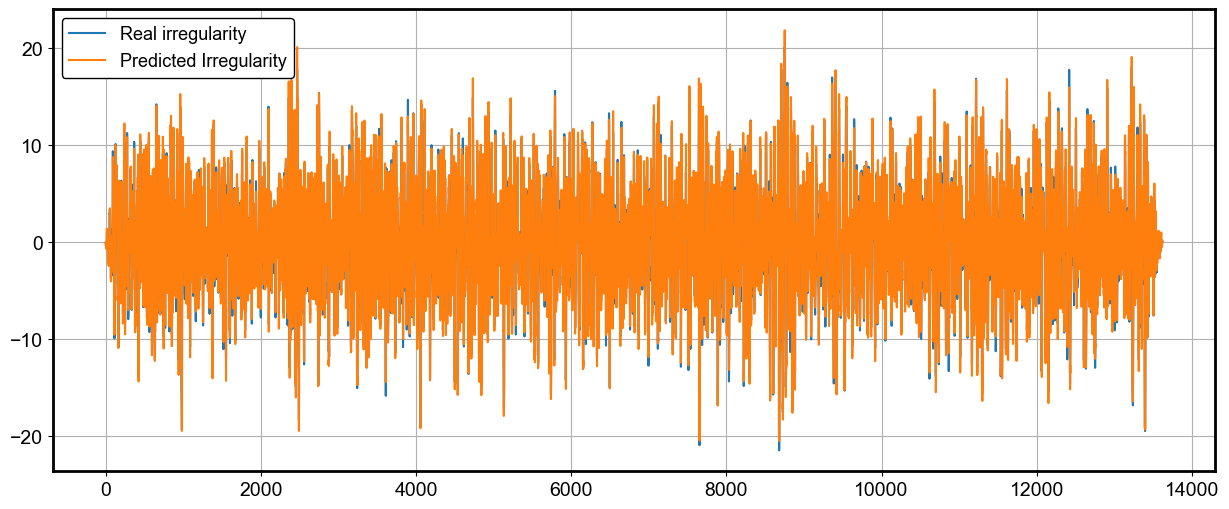

In [33]:
plt.plot(y_test_ordered,label='Real irregularity')
plt.plot(yhat, label='Predicted Irregularity')
plt.legend()

Text(0.5, 0, 'Distance (m)')

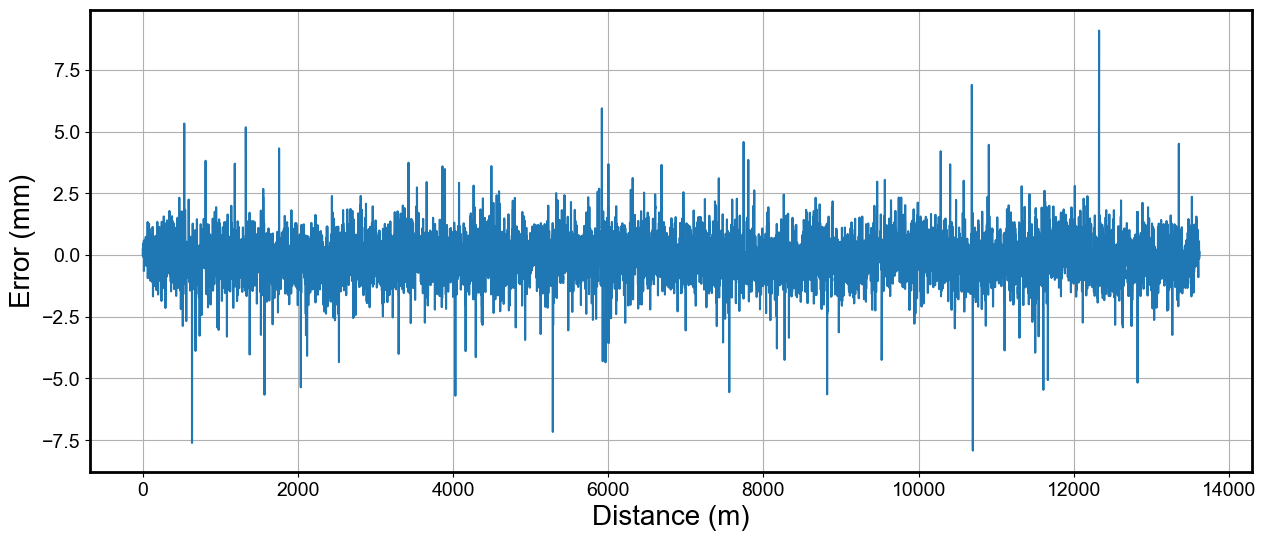

In [34]:
error = y_test_ordered - yhat
#error = yblau.to_numpy().reshape(-1, 1)- yhat
plt.plot(error)
plt.ylabel('Error (mm)')
plt.xlabel('Distance (m)')

(-20.0, 20.0)

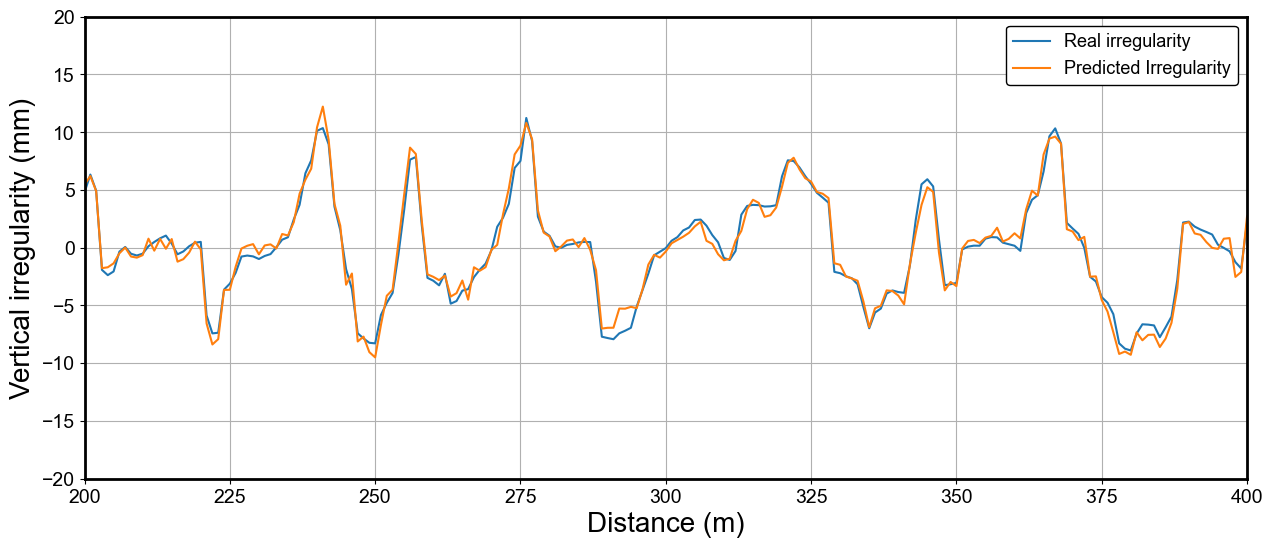

In [35]:
plt.plot(y_test_ordered,label='Real irregularity')
plt.plot(yhat,label='Predicted Irregularity')
plt.legend()
plt.ylabel('Vertical irregularity (mm)')
plt.xlabel('Distance (m)')

plt.xlim([200,400])
plt.ylim([-20,20])

Text(0.5, 0, 'Distance (m)')

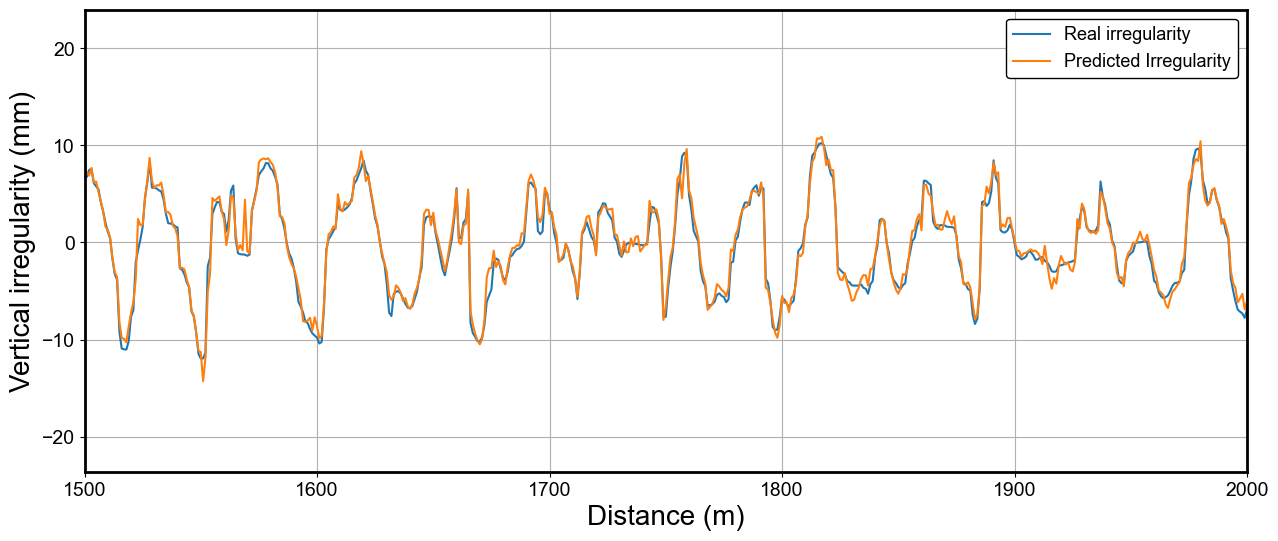

In [36]:
plt.plot(y_test_ordered, label='Real irregularity')
plt.plot(yhat, label='Predicted Irregularity')
plt.legend()
plt.xlim([1500, 2000])
plt.ylabel('Vertical irregularity (mm)')
plt.xlabel('Distance (m)')

# Visualizing Neural networks with Yellowbricks

Only works for vanilla neural networks

Source: https://github.com/ResidentMario/yellowbrick-x-keras/blob/master/notebooks/using-yellowbrick-with-keras-regressors.ipynb

In [37]:
from yellowbrick.regressor import ResidualsPlot
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.base import BaseEstimator, RegressorMixin


class KerasReg(BaseEstimator, RegressorMixin, KerasRegressor):

    def __init__(self, build_fn, **kwargs):
        super(KerasRegressor, self).__init__(build_fn,  **kwargs)


def keras_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(650, activation='linear'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(700, activation='linear'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(500, activation='tanh'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1150, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1, activation='linear'))

    learning_rate = 1e-4
    model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=learning_rate))

    return model

In [38]:
NN = KerasReg(keras_model, epochs=300, batch_size=2048, verbose=0)
NN

KerasReg(build_fn=<function keras_model at 0x0000019A0FC178B0>)

In [39]:
plt.rcParams.update({
    'font.size': 18,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'lines.linewidth': 1,
    'lines.markersize': 5,
    'figure.figsize': (25, 10),
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'font.family': 'Arial',
    'legend.fontsize': 14,
    'axes.labelsize': 20,
    'axes.grid': True,
})

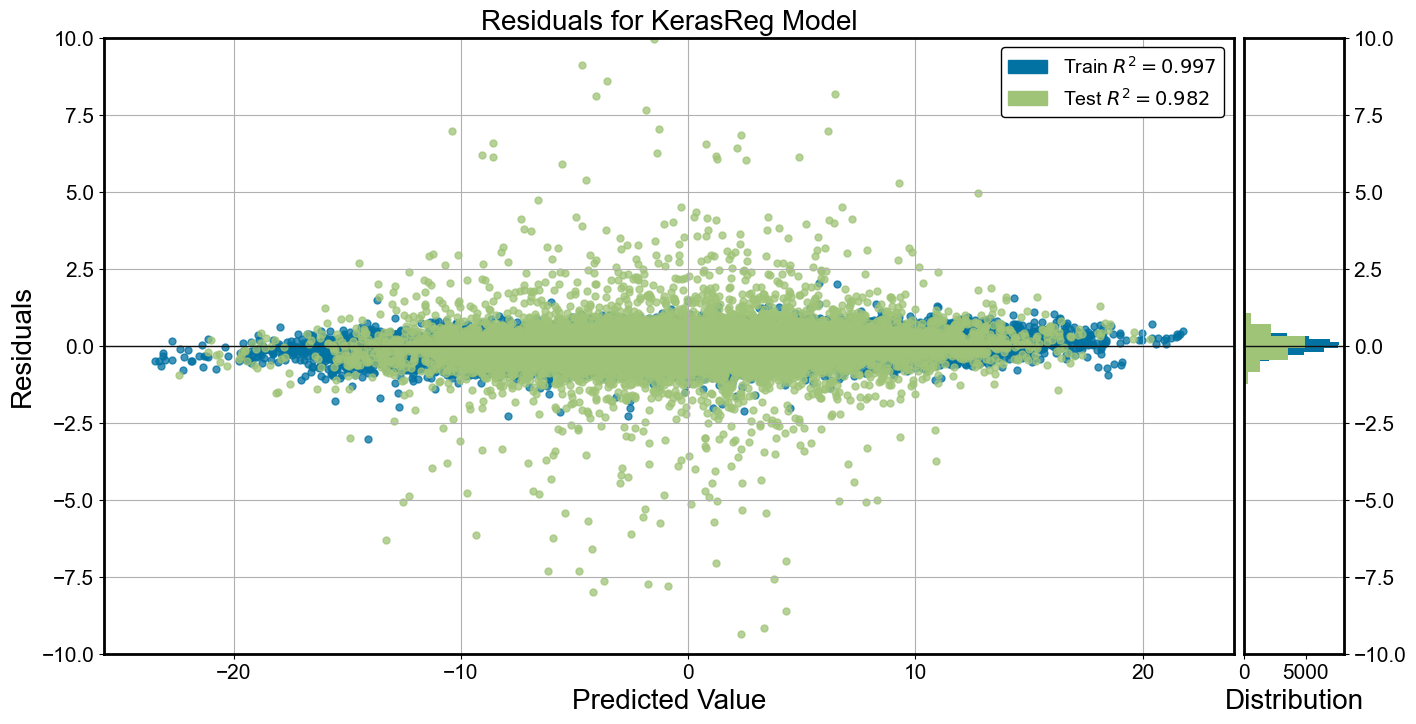

<AxesSubplot:title={'center':'Residuals for KerasReg Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [40]:
from yellowbrick.regressor import ResidualsPlot

fig, ax = plt.subplots(figsize=(16, 8))

visualizer = ResidualsPlot(NN, ax=ax)
visualizer.fit(X_train1, y_train1)
visualizer.score(X_test1, y_test1)
ax.set_ylim([-10,10])

visualizer.poof()